**Abstract**: this is a classical sentiment analysis problem. The input is a variable length text and the output is one of the 12 classes. One naive solution is to use the TFIDF model. This model relies on the statistics of the characters in each text to make the prediction. The drawback of this model is that it cannot capture the dependency between consecutive characters, hence loses valuable information there.

RNN is better suited for this problem as it respects the order of the characters in a sequence. So we are going to try 2 different RNN models for this problem. The 1st RNN model is a standard LSTM architecture, which can be found in the Keras sample applications (https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py). It simply contains an LSTM model and a Dense layer.

*Model 1: LSTM => Dense* (accuracy result: 25.1%)

The 2nd model that we are going to try is much more complicated than the 1st model. It uses a stack of CNN layers to process the text before feeding to a Bidirectional LSTM. This architecture was found to perform the best among the alternatives in https://arxiv.org/pdf/1602.02410.pdf. The CNN layers are to discover the words with strong sentiment that may be more relevant to the label of the whole text.

*Model 2: CNN => CNN => CNN => Bidirectional LSTM => Dense => Dense* (accuracy result: 84.7%)

# Make the train set and the validation set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Embedding, LSTM, Conv1D, Dropout, MaxPooling1D, Bidirectional
%matplotlib inline

/home/andy/anaconda2/envs/tf/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# read the text and the labels from files
x_train = []

for line in open('xtrain_obfuscated.txt'):
    x_train += [line.strip()]
    
y_train = []
for line in open('ytrain.txt'):
    y_train += [int(line)]

## Preprocess input text

all characters: ['a', 'c', 'b', 'e', 'd', 'g', 'f', 'i', 'h', 'k', 'j', 'm', 'l', 'o', 'n', 'q', 'p', 's', 'r', 'u', 't', 'w', 'v', 'y', 'x', 'z'] 

number of characters: 26 

histogram of line lengths (max 452)


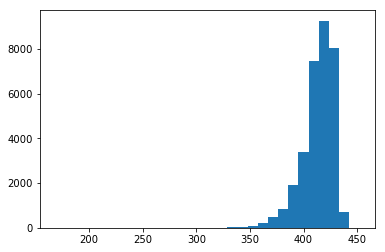

In [3]:
# find out all characters in the text
all_chars = set()
all_lens = []

for line in x_train:
    for char in line:
        all_chars.add(char)
    all_lens += [len(line)]
    
# make the dictionary to map character to index
all_chars = list(all_chars)
all_chars = {all_chars[i]:(i+1) for i in range(len(all_chars))}

# plus 1 to account for the padding
max_features = len(all_chars) + 1

# max length of lines
max_len = max(all_lens)

# convert characters to indices using all_chars dictionary
for i, line in enumerate(x_train):
    x_train[i] = [all_chars[char] for char in line]
    
# pad shorter lines to max_len
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
        
print 'all characters:', all_chars.keys(), '\n'
print 'number of characters:', len(all_chars), '\n'
print 'histogram of line lengths (max ' + str(max_len) + ')'
_ = plt.hist(all_lens, bins=30)

## Preprocess the labels

In [4]:
# find out all the labels in the labels
all_labels = set()

for label in y_train:
    all_labels.add(label)
    
nb_labels = len(all_labels)

# convert y_train to one-hot encoding
indices = np.array(y_train)
y_train = np.zeros((len(indices), nb_labels))
y_train[np.arange(len(indices)), indices] = 1
        
print 'all labels:', all_labels, '\n'
print 'number of labels:', nb_labels

all labels: set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]) 

number of labels: 12


In [5]:
# split the data into the train set and the validation set
np.random.seed(0)
nb_exam = len(x_train)
indices = np.random.permutation(nb_exam)

x_valid = x_train[indices[int(nb_exam*0.85):]]
y_valid = y_train[indices[int(nb_exam*0.85):]]

x_train = x_train[indices[:int(nb_exam*0.85)]]
y_train = y_train[indices[:int(nb_exam*0.85)]]
np.random.seed()

print 'x_train shape:', x_train.shape
print 'y_train shape:', y_train.shape

print 'x_valid shape:', x_valid.shape
print 'y_valid shape:', y_valid.shape

x_train shape: (27636, 452)
y_train shape: (27636, 12)
x_valid shape: (4877, 452)
y_valid shape: (4877, 12)


# Make and train 2 RNN model

## Model 1: vanila model for sentiment analysis

In [6]:
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
batch_size = 256

early_stop = EarlyStopping(monitor='val_acc', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='max', 
                           verbose=1)

checkpoint = ModelCheckpoint('model_1.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             period=1)

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=100,
          callbacks=[early_stop, checkpoint],
          validation_data=(x_valid, y_valid))

Train on 27636 samples, validate on 4877 samples
Epoch 1/100
27636/27636 [==============================] - 97s 4ms/step - loss: 2.2102 - acc: 0.2105 - val_loss: 2.2150 - val_acc: 0.2253

Epoch 00001: val_acc improved from -inf to 0.22534, saving model to model_1.h5
Epoch 2/100
27636/27636 [==============================] - 98s 4ms/step - loss: 2.2095 - acc: 0.2086 - val_loss: 2.1329 - val_acc: 0.2506

Epoch 00002: val_acc improved from 0.22534 to 0.25056, saving model to model_1.h5
Epoch 3/100
27636/27636 [==============================] - 98s 4ms/step - loss: 2.1938 - acc: 0.2132 - val_loss: 2.1902 - val_acc: 0.2094

Epoch 00003: val_acc did not improve
Epoch 4/100
27636/27636 [==============================] - 97s 4ms/step - loss: 2.1915 - acc: 0.2131 - val_loss: 2.1793 - val_acc: 0.2130

Epoch 00004: val_acc did not improve
Epoch 5/100
27636/27636 [==============================] - 97s 4ms/step - loss: 2.1808 - acc: 0.2167 - val_loss: 2.1408 - val_acc: 0.2321

Epoch 00005: val_acc 

In [10]:
model.load_weights('model_1.h5')
score, acc = model.evaluate(x_valid, 
                            y_valid,
                            batch_size=batch_size)

print('Validation score:', score)
print('Validation accuracy:', acc)

4877/4877 [==============================] - 4s 903us/step
('Validation score:', 2.1329242040173844)
('Validation accuracy:', 0.2505638712628689)


## Model 2: CNN and Bidirectional LSTM

In [15]:
filter_length = [5, 3, 3]
nb_filter = [196, 196, 256]
pool_length = 2

model = Sequential()

model.add(Embedding(max_features, 128))

for i in range(len(nb_filter)):
    model.add(Conv1D(filters=nb_filter[i],
                     kernel_size=filter_length[i],
                     padding='valid',
                     activation='relu',
                     kernel_initializer='glorot_normal',
                     strides=1))
    model.add(Dropout(0.15))
    model.add(MaxPooling1D(pool_size=pool_length))

model.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.15, recurrent_dropout=0.15)))

model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
batch_size = 256

early_stop = EarlyStopping(monitor='val_acc', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='max', 
                           verbose=1)

checkpoint = ModelCheckpoint('model_2.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             period=1)

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=100,
          callbacks=[early_stop, checkpoint],
          validation_data=(x_valid, y_valid))

Train on 27636 samples, validate on 4877 samples
Epoch 1/100
27636/27636 [==============================] - 44s 2ms/step - loss: 0.2764 - acc: 0.9101 - val_loss: 0.5881 - val_acc: 0.8343

Epoch 00001: val_acc improved from -inf to 0.83432, saving model to model_2.h5
Epoch 2/100
27636/27636 [==============================] - 44s 2ms/step - loss: 0.2825 - acc: 0.9056 - val_loss: 0.5507 - val_acc: 0.8474

Epoch 00002: val_acc improved from 0.83432 to 0.84745, saving model to model_2.h5
Epoch 3/100
27636/27636 [==============================] - 44s 2ms/step - loss: 0.2793 - acc: 0.9079 - val_loss: 0.5660 - val_acc: 0.8378

Epoch 00003: val_acc did not improve
Epoch 4/100
27636/27636 [==============================] - 44s 2ms/step - loss: 0.2726 - acc: 0.9127 - val_loss: 0.5528 - val_acc: 0.8442

Epoch 00004: val_acc did not improve
Epoch 5/100
27636/27636 [==============================] - 44s 2ms/step - loss: 0.2654 - acc: 0.9151 - val_loss: 0.5523 - val_acc: 0.8466

Epoch 00005: val_acc 

In [20]:
model.load_weights('model_2.h5')
score, acc = model.evaluate(x_valid, 
                            y_valid,
                            batch_size=batch_size)

print('Validation score:', score)
print('Validation accuracy:', acc)

4877/4877 [==============================] - 2s 441us/step
('Validation score:', 0.550671717543472)
('Validation accuracy:', 0.8474472011482469)


# Make predictions on test set

In [42]:
# read the text from file
x_test = []

for line in open('xtest_obfuscated.txt'):
    x_test += [line.strip()]
    
# convert characters to indices using all_chars dictionary
for i, line in enumerate(x_test):
    x_test[i] = [all_chars[char] for char in line]
    
# pad shorter lines to max_len
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

# write results to file
y_test = model.predict(x_test)
y_test = np.argmax(y_test, axis=1)

with open('ytest.txt', 'w') as ytest:
    for label in y_test:
        ytest.write(str(label) + '\n')